# Expiremental features we extracted during our research
All the features we didn't use in our final project

In [1]:
%load_ext autoreload
%autoreload 2
data_dir = "./data/"
from utilities import *

In [2]:
import librosa # for working with audio in python
import librosa.display # for waveplots, spectograms, etc
import soundfile as sf # for accessing file information
import IPython.display as ipd # for playing files within python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

In [3]:
musics = load_musics(data_dir + "musics/")

# Start
At first we tried to extract every features aviable with librosa without fully understanding their purpose

In [13]:
def chroma_stft_mean(m):
    y, sr = m
    y = librosa.effects.harmonic(y)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    return tonnetz.mean()

In [14]:
def spectral_centroid_std(m):
    cent = spect_cent(m)
    return np.std(cent)

In [15]:
def amplitude_std(m) -> float:
    y, sr = m
    return np.std(y)

In [16]:
def chroma_stft_std(m):
    y, sr = m
    y = librosa.effects.harmonic(y)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    return np.std(tonnetz)

# Correlation
After extracting the values we calculated their correlation with our classe

In [24]:
df = pd.DataFrame({
    'chroma_stft_std' : musics.apply(chroma_stft_std),
    'amplitude_std' : musics.apply(amplitude_std),
    'spectral_centroid_std' : musics.apply(spectral_centroid_std),
    'chroma_stft_mean' : musics.apply(chroma_stft_mean),
    'spectral_centroid' : musics.apply(spectral_centroid_mean),
	'classe': musics.index.map(lambda name: 1 if name[0] == 'a' else -1),
})

In [25]:
dfstd = df
dfstd = (df - df.mean()) / df.std()
dfstd["classe"] = df["classe"]

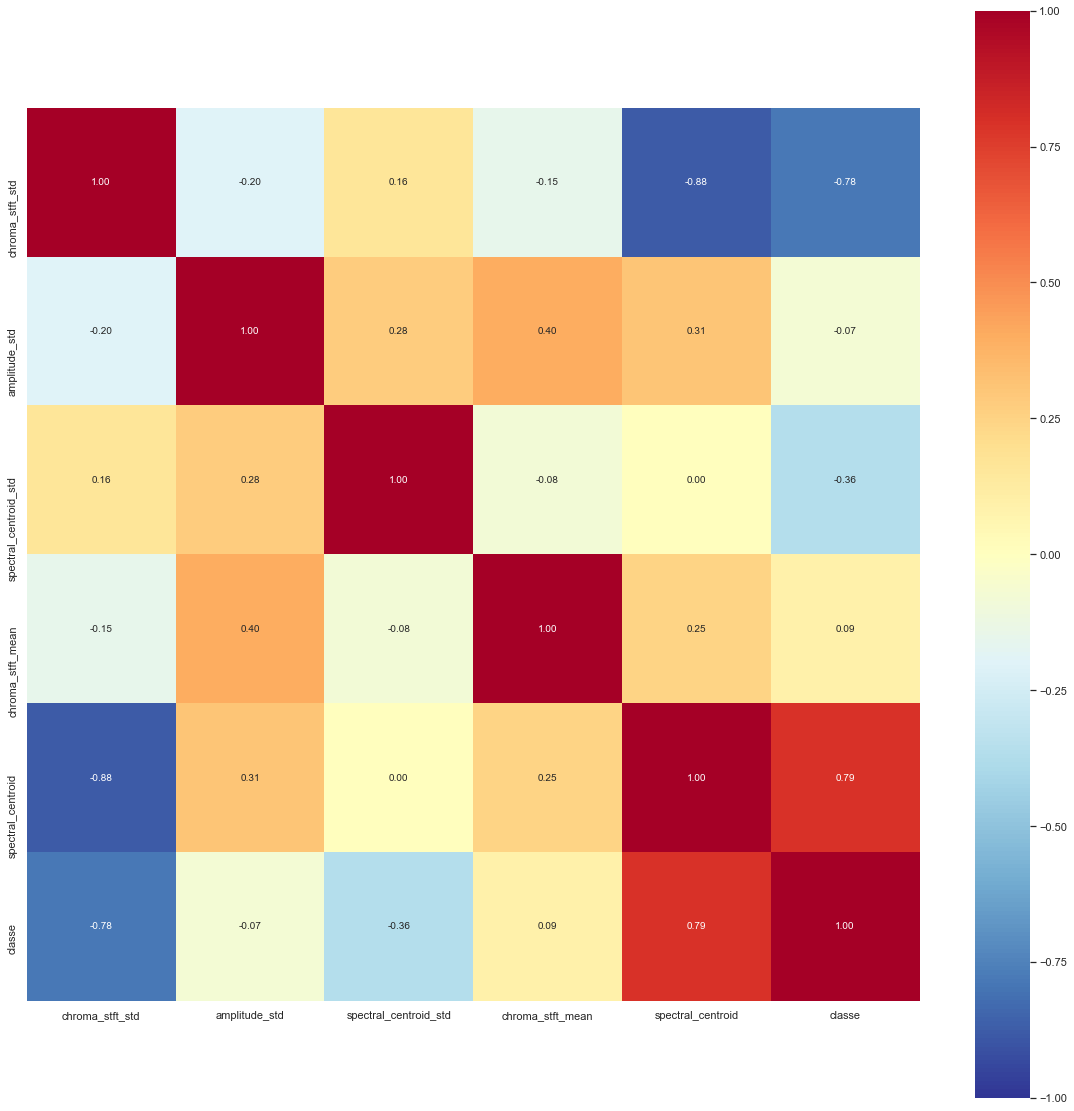

In [26]:
fig = Figure(figsize=(20,20))
sns.heatmap(dfstd.corr(), fmt='0.2f', annot=True, square=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=fig.add_subplot())
fig

# plot
Even if their correlation was low we still tried to plot this features to see if it helped ou to determine if a song was happy or sad

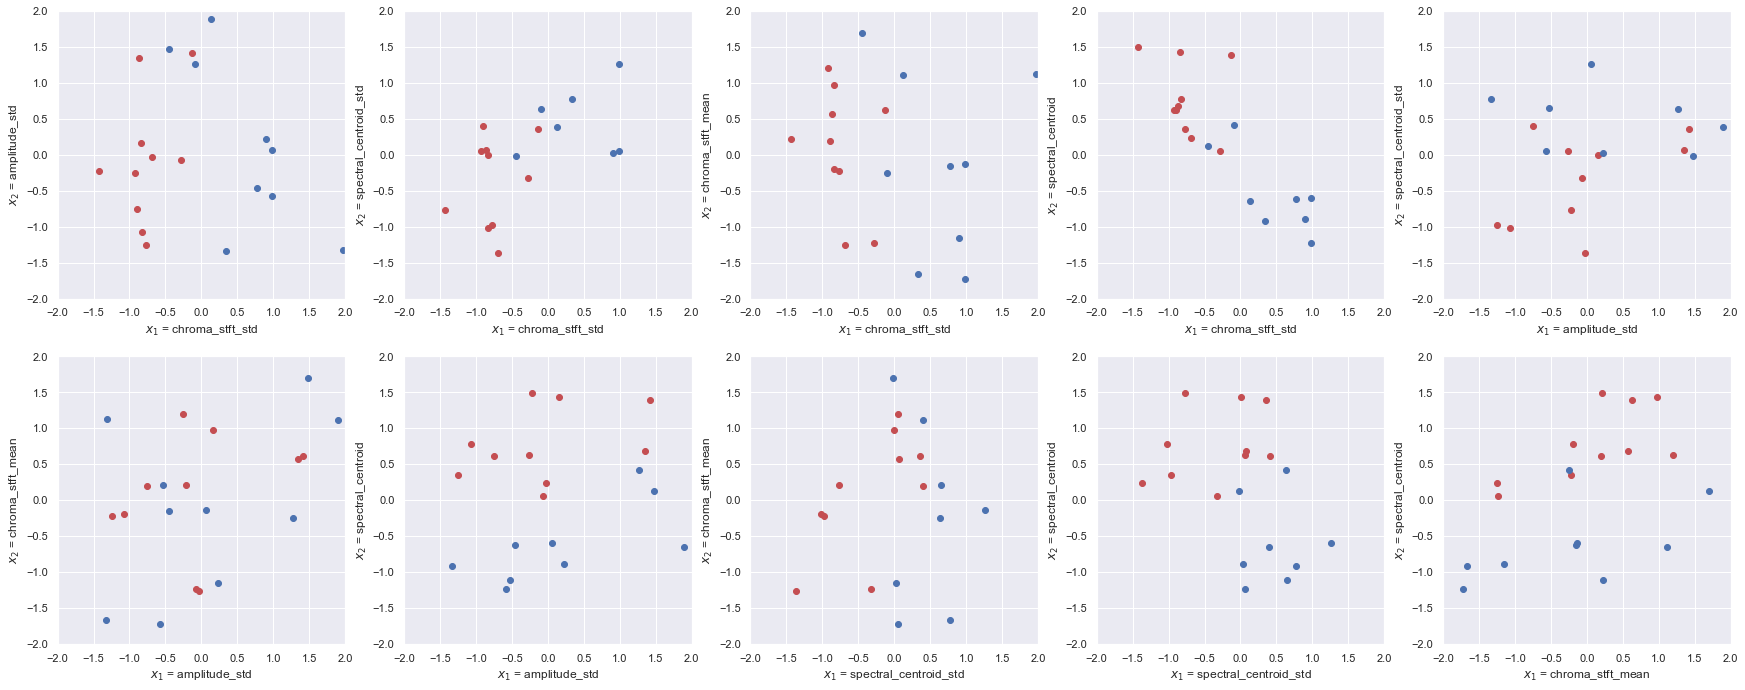

In [27]:
make_scatter_plot3(dfstd)

# Scale
Téo Sanchez gave us an idea of a features that we could extract  
The scale of the music  
If the music is in major scale, the music is happy  
If the music is in minor scale, the music is Sad

# Naive option
To extract this features we first tried to compute the mean of each scale with the chroma extraction, then look at the most used one. If the third scale after is the second most commonly used than it is in minor scale, if it is the fourth one it is in major scale

In [35]:
def scale_extraction(m):
    y, sr = m
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma = [c.mean() for c in chroma_cq]
    pitch_id = chroma.index(max(chroma))
    min_third_id = (pitch_id+3)%12
    maj_third_id = (pitch_id+4)%12
    return chroma[min_third_id] - chroma[maj_third_id]

In [36]:
df = pd.DataFrame({
    'scale' : musics.apply(scale_extraction),
    'spectral_centroid' : musics.apply(spectral_centroid_mean),
	'classe': musics.index.map(lambda name: 1 if name[0] == 'a' else -1),
})

In [37]:
dfstd = df
dfstd = (df - df.mean()) / df.std()
dfstd["classe"] = df["classe"]

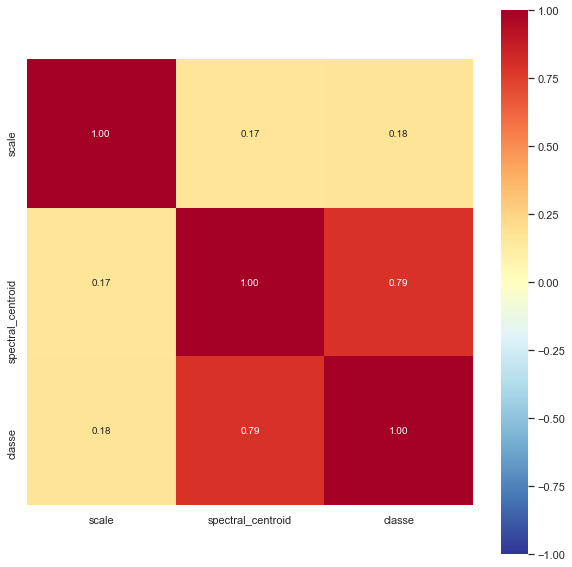

In [38]:
fig = Figure(figsize=(10,10))
sns.heatmap(dfstd.corr(), fmt='0.2f', annot=True, square=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=fig.add_subplot())
fig

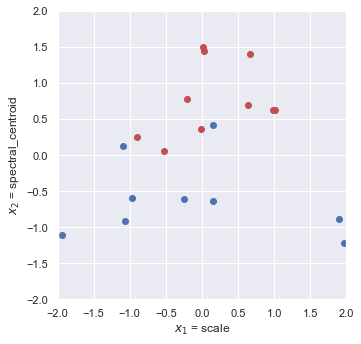

In [39]:
make_scatter_plot3(dfstd)

# Result
The result was a bit disapointing, their was no clear correlation, and it didn't helped to increase the precision of our extraction with the spectral centroid

# Clever option
Once again Téo Sanchez helped us and told us that the lack of correlation was maybe due to the fact we extracted the scale with all the music without any filter. And the main scale that we extracted wasn't the main scale of the harmonic content

We tried to method to extract lower frequency of our music
# 1st method

In [42]:
from scipy import signal

def scale_extraction_clever(m):
    y, sr = m
    sf = sr   #Sampling frequency
    #Creation of the filter
    cutOff = 80 # Cutoff frequency in Hz
    nyq = 0.5 * sf
    N  = 6    # Filter order: if you increase, the cutting in the frequency is more abrubt
    fc = cutOff / nyq # Cutoff frequency normal
    b, a = signal.butter(N, fc) #butterworth filter
    #Apply the filter
    myFilteredSound = signal.filtfilt(b,a, y)
    return scale_extraction((myFilteredSound, sr))

In [43]:
df = pd.DataFrame({
    'scale' : musics.apply(scale_extraction_clever),
    'spectral_centroid' : musics.apply(spectral_centroid_mean),
	'classe': musics.index.map(lambda name: 1 if name[0] == 'a' else -1),
})

/Users/fredericbecerril/opt/miniconda3/envs/upsud/lib/python3.9/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/Users/fredericbecerril/opt/miniconda3/envs/upsud/lib/python3.9/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [44]:
dfstd = df
dfstd = (df - df.mean()) / df.std()
dfstd["classe"] = df["classe"]

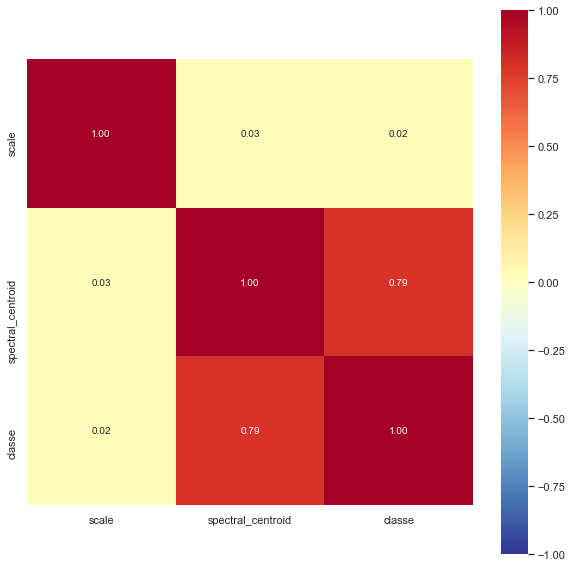

In [45]:
fig = Figure(figsize=(10,10))
sns.heatmap(dfstd.corr(), fmt='0.2f', annot=True, square=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=fig.add_subplot())
fig

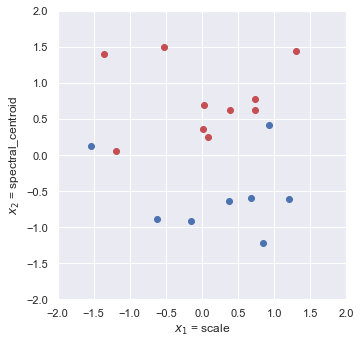

In [46]:
make_scatter_plot3(dfstd)

# 2nd method

In [54]:
def scale_extraction_clever2(m):
    y, sr = m
    S_full, phase = librosa.magphase(librosa.stft(y))
    S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))
    S_filter = np.minimum(S_full, S_filter)
    margin_i, margin_v = 2, 10
    power = 2
    mask_i = librosa.util.softmask(S_filter,
                                margin_i * (S_full - S_filter),
                                power=power)
    mask_v = librosa.util.softmask(S_full - S_filter,
                                margin_v * S_filter,
                                power=power)
    S_background = mask_i * S_full
    D_background = S_background * phase
    y_background = librosa.istft(D_background)
    return scale_extraction((y_background, sr))

In [55]:
df = pd.DataFrame({
    'scale' : musics.apply(scale_extraction_clever2),
    'spectral_centroid' : musics.apply(spectral_centroid_mean),
	'classe': musics.index.map(lambda name: 1 if name[0] == 'a' else -1),
})

In [56]:
dfstd = df
dfstd = (df - df.mean()) / df.std()
dfstd["classe"] = df["classe"]

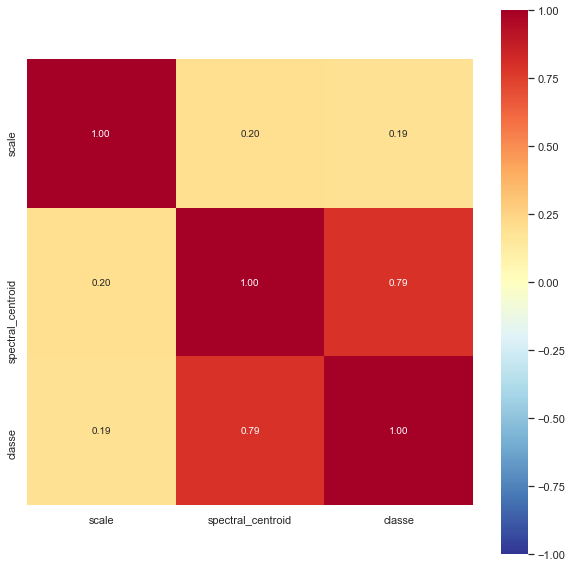

In [57]:
fig = Figure(figsize=(10,10))
sns.heatmap(dfstd.corr(), fmt='0.2f', annot=True, square=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=fig.add_subplot())
fig

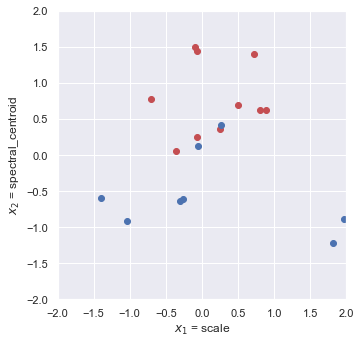

In [58]:
make_scatter_plot3(dfstd)

# Result
The result here was dispointing as we didn't found any correlation, and the seconde method is very slow to compute  
We may have done some mistake making the filter, so the idea of extracting the scale might be the right one to determine if a music is happy or sad